In [ ]:
!pip install biotorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from biotorch.layers.usf import Conv2d, Linear
from biotorch.module.biomodule import BioModule

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = Linear(in_features=128*8*8, out_features=256)
        self.fc2 = Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = CustomCNN()
# Wrap the model with BioModule for backpropagation
bp_model = BioModule(module=model, mode='backpropagation')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def train(model, trainloader, criterion, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

train(bp_model, trainloader, criterion, optimizer, device, epochs=100)

def evaluate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total}%')

evaluate(bp_model, testloader, device)

Module has been converted to backpropagation mode:

The layer configuration was:  {'type': 'backpropagation', 'options': {'constrain_weights': False, 'gradient_clip': False, 'init': 'xavier'}}
- All the 3 <class 'biotorch.layers.usf.conv.Conv2d'> layers were converted successfully.
- All the 2 <class 'biotorch.layers.usf.linear.Linear'> layers were converted successfully.
Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.3726345060579002
Epoch 2, Loss: 0.9911870507480544
Epoch 3, Loss: 0.8397697642864779
Epoch 4, Loss: 0.7387199149564709
Epoch 5, Loss: 0.6516540947243991
Epoch 6, Loss: 0.578456734338075
Epoch 7, Loss: 0.5106553714103101
Epoch 8, Loss: 0.4437457121660947
Epoch 9, Loss: 0.3916594699368148
Epoch 10, Loss: 0.3426761984101037
Epoch 11, Loss: 0.28740460940105533
Epoch 12, Loss: 0.24567118098440072
Epoch 13, Loss: 0.20780939090511072
Epoch 14, Loss: 0.1726847502219555
Epoch 15, Loss: 0.14488754199003168
Epoch 16, Loss: 0.120522415970

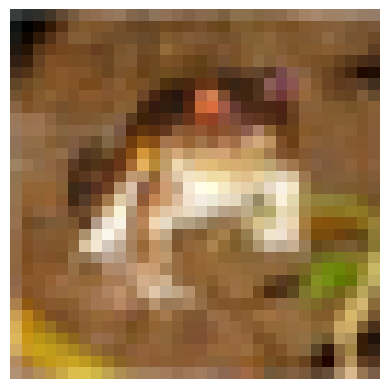

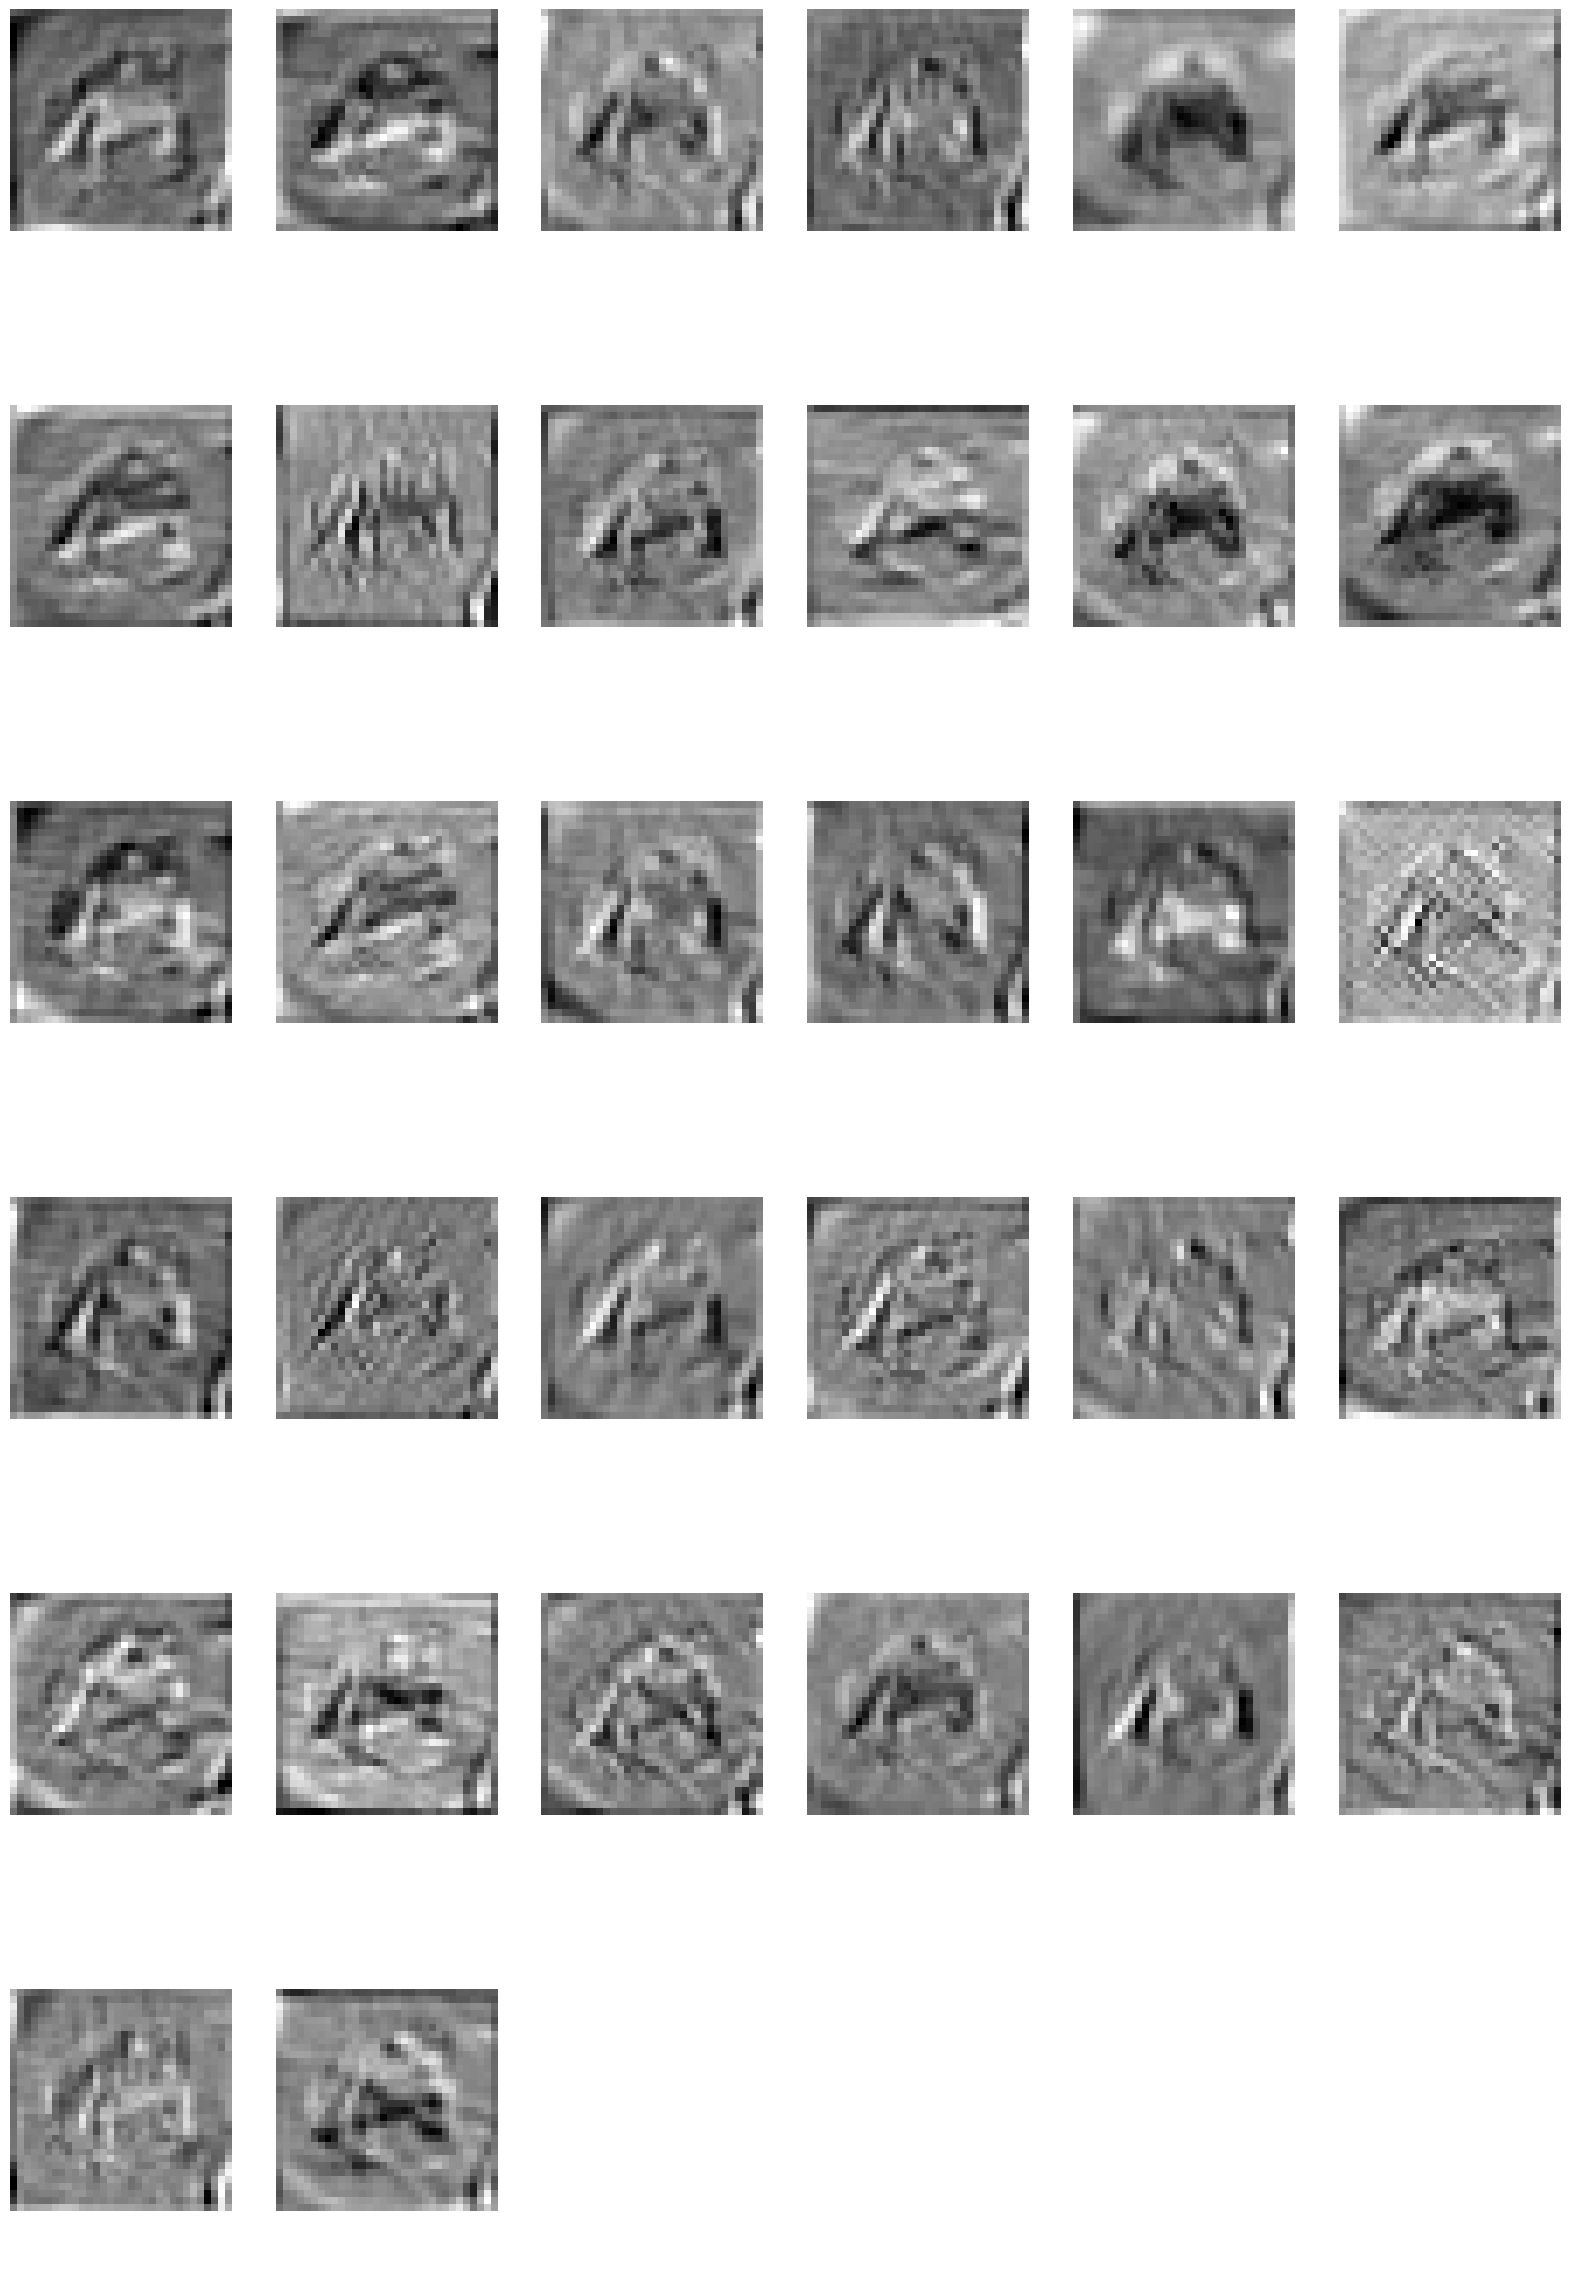

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_filters(layer, num_filters=6):
    filters = layer.weight.data.cpu().numpy()
    fig, axes = plt.subplots(1, num_filters, figsize=(20, 5))
    for i in range(num_filters):
        filter = filters[i, 0, :, :]
        axes[i].imshow(filter, cmap='gray')
        axes[i].axis('off')
    plt.show()

def visualize_activation(model, layer, input_image, num_cols=6):
    activations = []
    hooks = []

    def hook_fn(module, input, output):
        activations.append(output)

    hooks.append(layer.register_forward_hook(hook_fn))

    model(input_image)

    for hook in hooks:
        hook.remove()

    activation = activations[0].squeeze().cpu().detach().numpy()
    num_activations = activation.shape[0]
    num_rows = np.ceil(num_activations / num_cols).astype(int)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    for i in range(num_activations):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].imshow(activation[i], cmap='gray')
        axes[row, col].axis('off')

    for i in range(num_activations, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')

    plt.show()

def show_original_image(image):
    img = image.cpu().squeeze().numpy().transpose(1, 2, 0)
    img = (img * 0.5) + 0.5  # Unnormalize the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Load a sample image from the CIFAR-10 dataset
sample_image, _ = trainset[0]
sample_image = sample_image.unsqueeze(0).to(device)

# Show the original image
show_original_image(sample_image)

# Visualize activation maps of the first convolutional layer
visualize_activation(bp_model, model.conv1, sample_image)

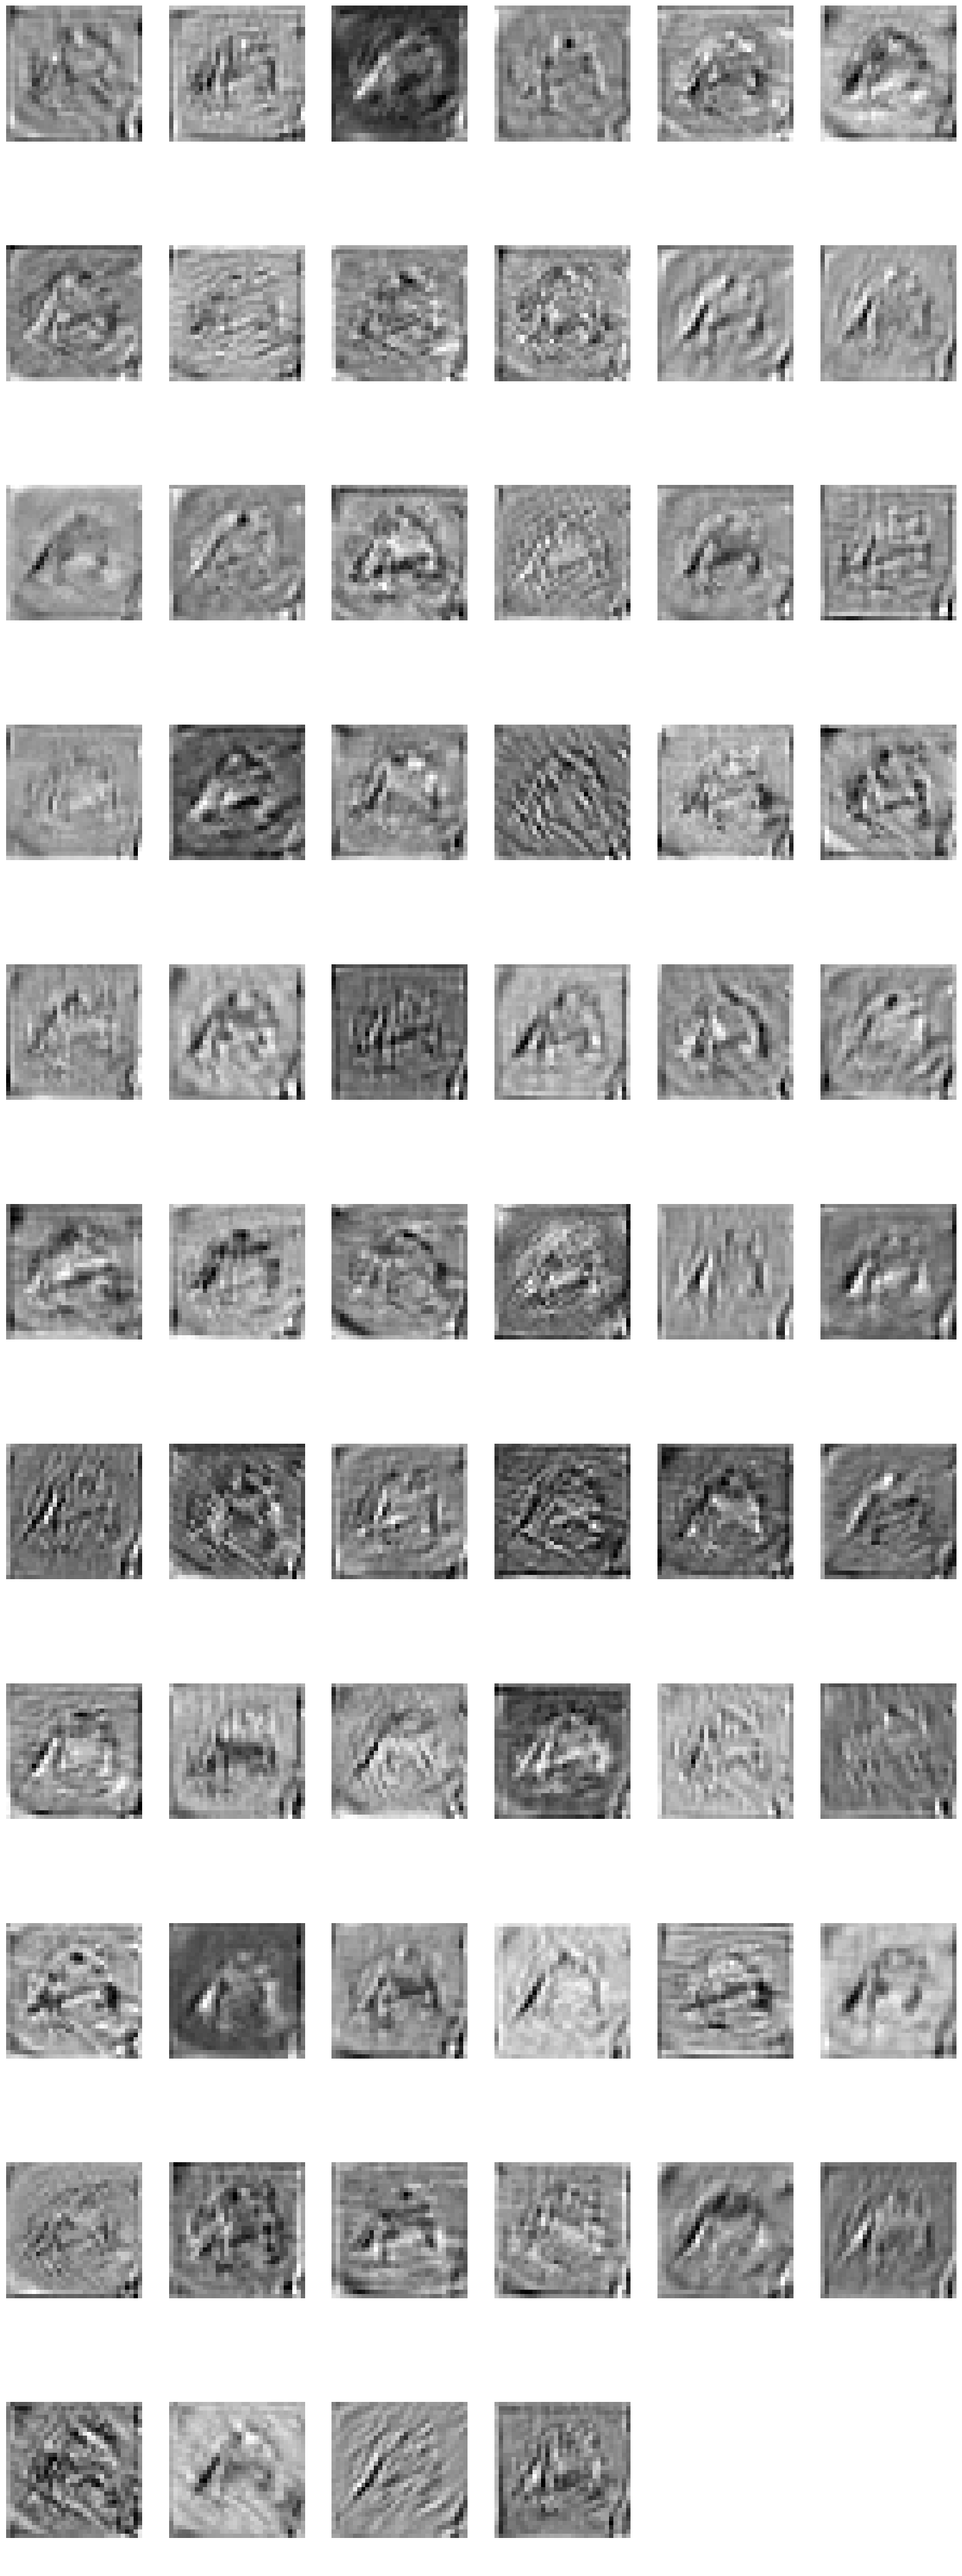

In [ ]:
# Visualize activation maps of the second convolutional layer
visualize_activation(bp_model, model.conv2, sample_image)

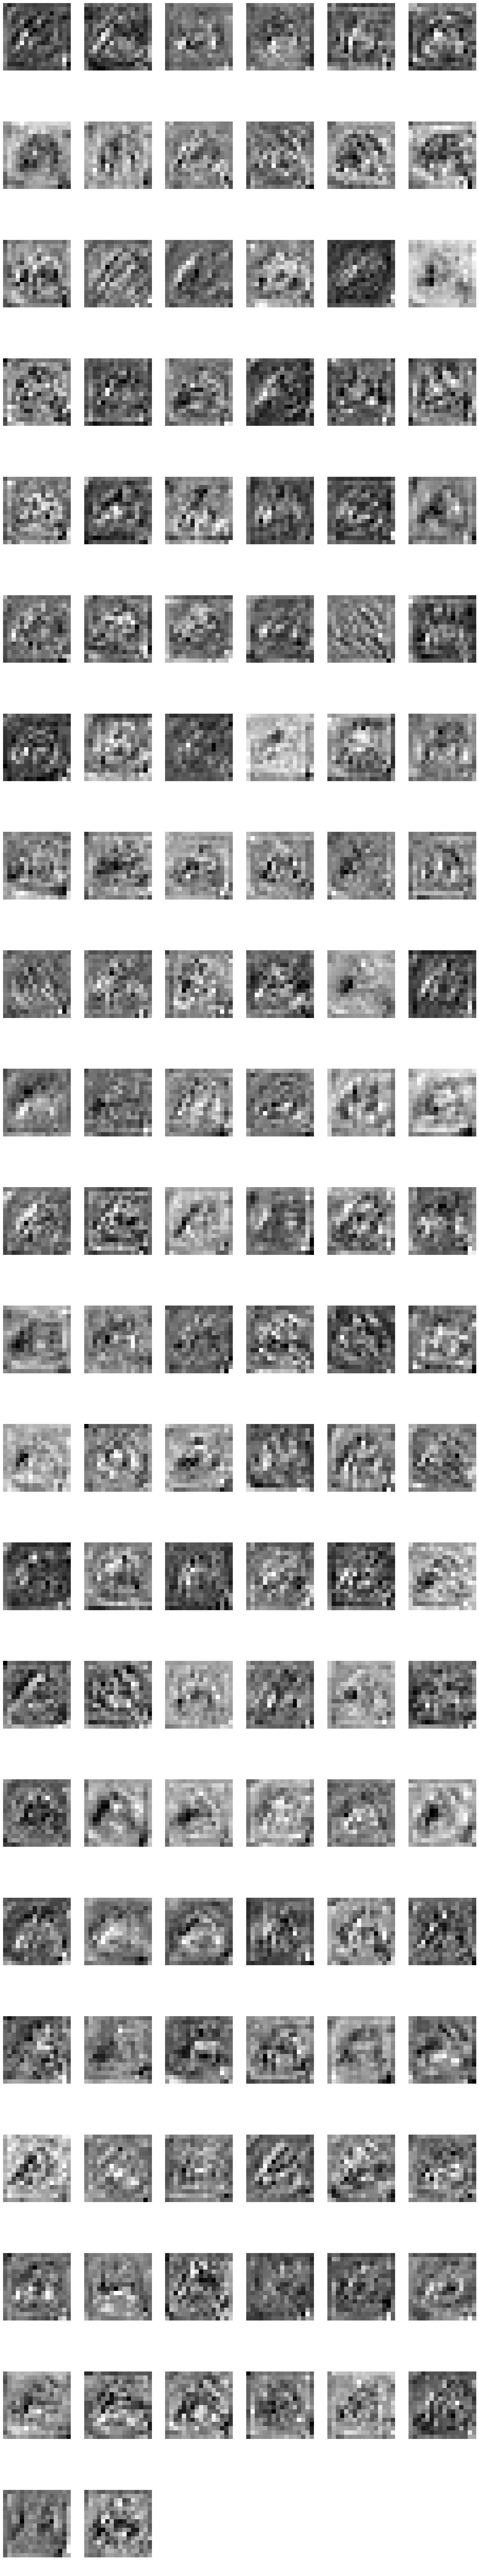

In [ ]:
# Visualize activation maps of the third convolutional layer
visualize_activation(bp_model, model.conv3, sample_image)

In [ ]:
!pip install -q ipympl ipywidgets mpl_interactions["jupyter"] rsatoolbox torchlens
!pip install -q graphviz

!pip install -q torchlens
!pip install -q ipympl ipywidgets matplotlib numpy scikit-learn torch torchvision rsatoolbox scipy
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# @title Import dependencies

# Import future dependencies
from __future__ import print_function

# Standard library imports
import argparse
import warnings
import logging
from collections import OrderedDict

# Third-party library imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from scipy import stats
import ipywidgets as widgets

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms, datasets
import torchlens as tl
from torchvision.utils import make_grid

# scikit-learn imports
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import linear_kernel

# rsatoolbox imports
import rsatoolbox
from rsatoolbox.data import Dataset
from rsatoolbox.rdm.calc import calc_rdm

# Jupyter-specific imports
%matplotlib inline

from __future__ import print_function

# Standard library imports
import argparse
import warnings
import logging
from collections import OrderedDict

# Third-party library imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from scipy import stats
import ipywidgets as widgets

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms, datasets

from torchvision.utils import make_grid

# scikit-learn imports
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import linear_kernel

import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F

from biotorch.benchmark.run import Benchmark
from biotorch.module.biomodule import BioModule

In [ ]:
def calc_rdms(model_features, method='correlation'):
    """
    Calculates representational dissimilarity matrices (RDMs) for model features.

    Inputs:
    - model_features (dict): A dictionary where keys are layer names and values are features of the layers.
    - method (str): The method to calculate RDMs, e.g., 'correlation'. Default is 'correlation'.

    Outputs:
    - rdms (pyrsa.rdm.RDMs): RDMs object containing dissimilarity matrices.
    - rdms_dict (dict): A dictionary with layer names as keys and their corresponding RDMs as values.
    """
    ds_list = []
    for l in range(len(model_features)):
        layer = list(model_features.keys())[l]
        feats = model_features[layer]

        if type(feats) is list:
            feats = feats[-1]

        feats = feats.cpu()

        if len(feats.shape) > 2:
            feats = feats.flatten(1)

        feats = feats.detach().numpy()
        ds = Dataset(feats, descriptors=dict(layer=layer))
        ds_list.append(ds)

    rdms = calc_rdm(ds_list, method=method)
    rdms_dict = {list(model_features.keys())[i]: rdms.get_matrices()[i] for i in range(len(model_features))}

    return rdms, rdms_dict


def extract_features(model, imgs, return_layers, plot='none'):
    """
    Extracts features from specified layers of the model.

    Inputs:
    - model (torch.nn.Module): The model from which to extract features.
    - imgs (torch.Tensor): Batch of input images.
    - return_layers (list): List of layer names from which to extract features.
    - plot (str): Option to plot the features. Default is 'none'.

    Outputs:
    - model_features (dict): A dictionary with layer names as keys and extracted features as values.
    """
    model_history = tl.log_forward_pass(model, imgs, layers_to_save='all', vis_opt=plot)
    model_features = {}
    for layer in return_layers:
        model_features[layer] = model_history[layer].tensor_contents.flatten(1)

    return model_features

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


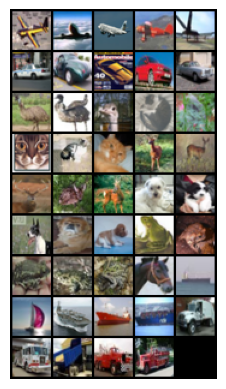

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def sample_images(data_loader, n=5, plot=False):
    """
    Samples a specified number of images from a data loader.

    Inputs:
    - data_loader (torch.utils.data.DataLoader): Data loader containing images and labels.
    - n (int): Number of images to sample per class.
    - plot (bool): Whether to plot the sampled images using matplotlib.

    Outputs:
    - imgs (torch.Tensor): Sampled images.
    - labels (torch.Tensor): Corresponding labels for the sampled images.
    """
    imgs, labels = next(iter(data_loader))

    imgs_o = []
    targets = []
    for value in range(10):
        value_indices = (labels == value).nonzero(as_tuple=True)[0]
        selected_imgs = imgs[value_indices][:n]
        imgs_o.append(selected_imgs)
        targets.extend([value] * n)

    imgs = torch.cat(imgs_o, dim=0)
    targets = torch.tensor(targets)

    if plot:
        grid_img = make_grid(imgs, nrow=n, padding=2, normalize=True, pad_value=0)
        plt.imshow(grid_img.permute(1, 2, 0))
        plt.axis('off')
        plt.show()

    return imgs, targets

# Example usage
# Assuming 'trainloader' is your data loader
imgs, targets = sample_images(trainloader, n=5, plot=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_maps(model_features, model_name):
    """
    Plots representational dissimilarity matrices (RDMs) across different layers of a model.

    Inputs:
    - model_features (dict): A dictionary where keys are layer names and values are numpy arrays representing RDMs for each layer.
    - model_name (str): The name of the model being visualized.
    """
    fig = plt.figure(figsize=(14, 4))
    fig.suptitle(f"RDMs across layers for {model_name}")
    gs = fig.add_gridspec(1, len(model_features))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)

    for l in range(len(model_features)):
        layer = list(model_features.keys())[l]
        map_ = np.squeeze(model_features[layer])

        if len(map_.shape) < 2:
            map_ = map_.reshape((int(np.sqrt(map_.shape[0])), int(np.sqrt(map_.shape[0]))))

        map_ = map_ / np.max(map_)

        ax = plt.subplot(gs[0, l])
        ax_ = ax.imshow(map_, cmap='magma_r')
        ax.set_title(f'{layer}')
        ax.set_xlabel("Input Index")
        if l == 0:
            ax.set_ylabel("Input Index")

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.6])
    cbar = fig.colorbar(ax_, cax=cbar_ax)
    cbar.set_label('Dissimilarity', rotation=270, labelpad=15)

    plt.show()

In [ ]:
bp_model

BioModule(
  (module): CustomCNN(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=8192, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=10, bias=True)
  )
)

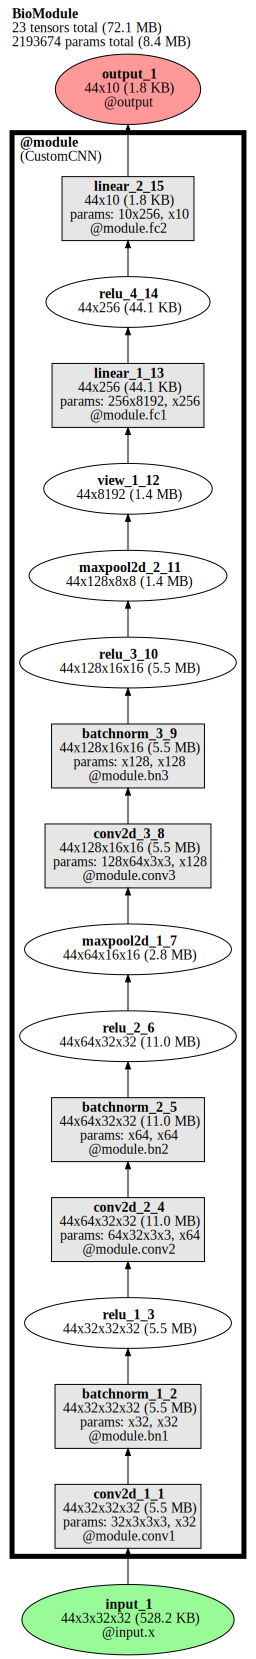

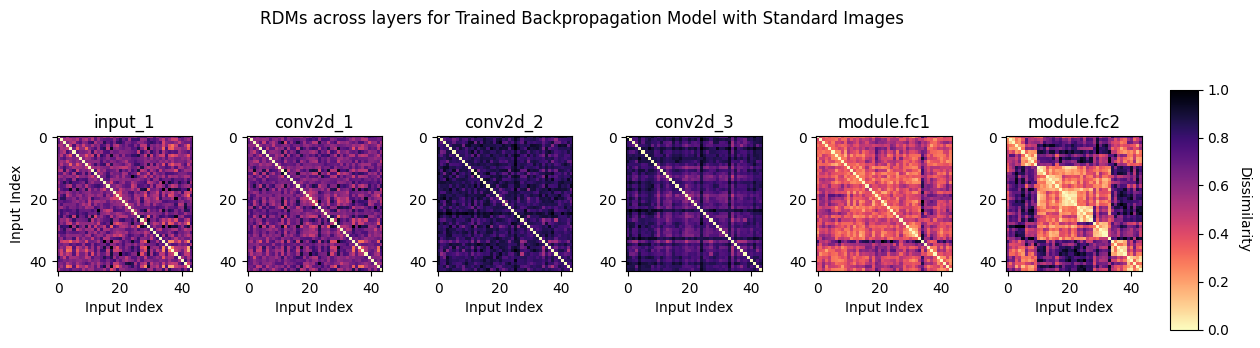

In [ ]:
return_layers = ['input_1', 'conv2d_1', 'conv2d_2', 'conv2d_3', 'module.fc1', 'module.fc2']
features_model_imgs = extract_features(bp_model, imgs, return_layers, plot = 'rolled')

rdms, rdms_dict = calc_rdms(features_model_imgs)
plot_maps(rdms_dict, "Trained Backpropagation Model with Standard Images")

Module has been converted to backpropagation mode:

The layer configuration was:  {'type': 'backpropagation', 'options': {'constrain_weights': False, 'gradient_clip': False, 'init': 'xavier'}}
- All the 3 <class 'biotorch.layers.usf.conv.Conv2d'> layers were converted successfully.
- All the 2 <class 'biotorch.layers.usf.linear.Linear'> layers were converted successfully.


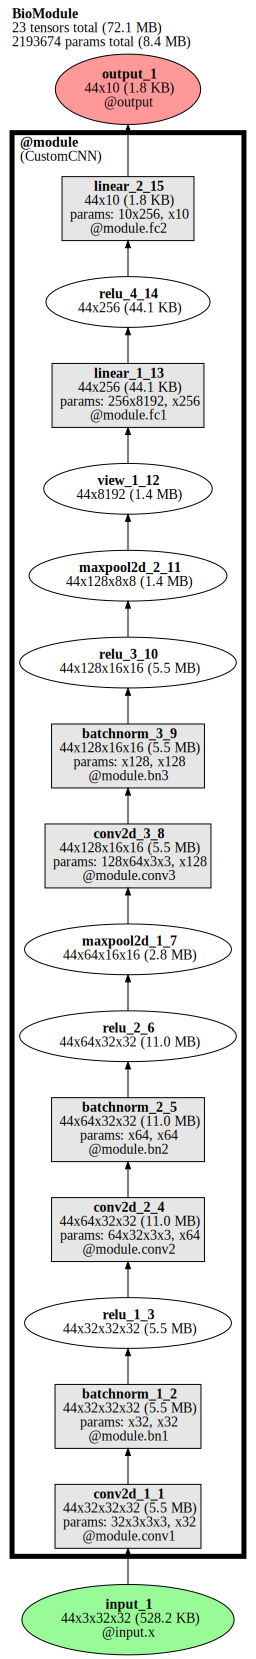

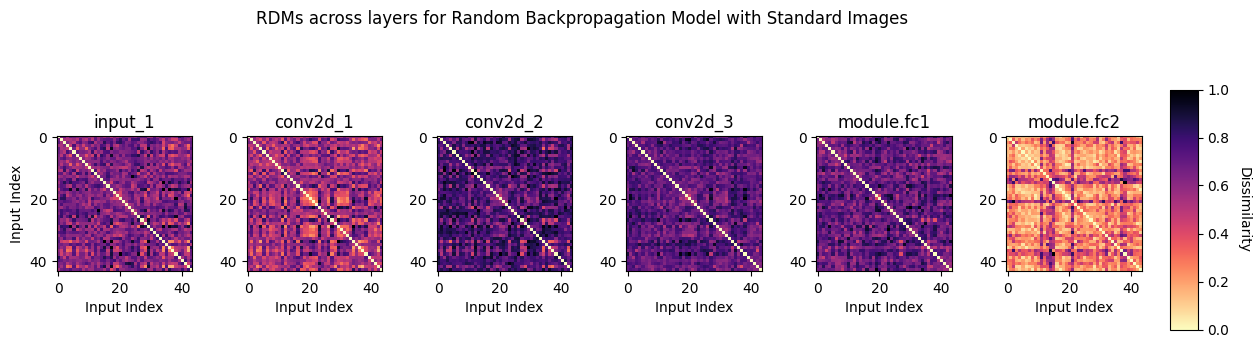

In [ ]:
rand_model = CustomCNN()
rand_bio_model = BioModule(module=rand_model, mode='backpropagation')

features_model_imgs = extract_features(rand_bio_model , imgs, return_layers, plot = 'rolled')

rdms, rdms_dict = calc_rdms(features_model_imgs)
plot_maps(rdms_dict, "Random Backpropagation Model with Standard Images")